Notebook to compare mean outgoing longwave radiation at toa from NextGEMS simulations (using Low Resolution Archive) with CERES (observations of radiation)

In [2]:
import matplotlib.pyplot as plt
from aqua import Reader

In case you want to run notebook with slurm

In [ ]:
from aqua.slurm import slurm
slurm.job(cores=8, memory="50 GB", jobs=1, queue = "interactive", walltime='00:30:00')

2023-05-29 18:01:35 :: create_folder :: WARNING  -> Folder ./slurm already exists
2023-05-29 18:01:35 :: create_folder :: WARNING  -> Folder ./slurm/logs already exists
2023-05-29 18:01:35 :: create_folder :: WARNING  -> Folder ./slurm/output already exists
/work/bb1153/b382216/mambaforge/envs/aqua/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35087 instead
  warnings.warn(
2023-05-29 18:01:46 :: slurm :: WARNING  -> #!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p interactive
#SBATCH -A bb1153
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=47G
#SBATCH -t 00:30:00
#SBATCH --error=./slurm/logs/dask-worker-%j.err
#SBATCH --output=./slurm/output/dask-worker-%j.out

/work/bb1153/b382216/mambaforge/envs/aqua/bin/python -m distributed.cli.dask_worker tcp://136.172.124.6:46785 --nthreads 2 --nworkers 4 --memory-limit 11.64GiB --name dummy-name --nanny --dea

In [ ]:
slurm.squeue()

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           5231577 interacti dask-wor  b382216  R       0:05      1 l40049


0

Explore the CERES catalogue (CERES is used as reference to compare models)

In [ ]:
reader = Reader(model="CERES", exp="ebaf-toa42", source="monthly")
data = reader.retrieve()
data

<xarray.Dataset>
Dimensions:                      (time: 275, lon: 360, lat: 180)
Coordinates:
  * time                         (time) datetime64[ns] 2000-03-15 ... 2023-01-15
  * lon                          (lon) float32 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * lat                          (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables:
    toa_sw_all_mon               (time, lat, lon) float32 dask.array<chunksize=(275, 180, 360), meta=np.ndarray>
    toa_lw_all_mon               (time, lat, lon) float32 dask.array<chunksize=(275, 180, 360), meta=np.ndarray>
    toa_net_all_mon              (time, lat, lon) float32 dask.array<chunksize=(275, 180, 360), meta=np.ndarray>
    toa_sw_clr_c_mon             (time, lat, lon) float32 dask.array<chunksize=(275, 180, 360), meta=np.ndarray>
    toa_lw_clr_c_mon             (time, lat, lon) float32 dask.array<chunksize=(275, 180, 360), meta=np.ndarray>
    toa_net_clr_c_mon            (time, lat, lon) float32 dask.array<chunksize=(275, 180, 360), meta=np.ndarray>
    solar_mon                    (time, lat, lon) float32 dask.array<chunksize=(275, 180, 360), meta=np.ndarray>
    cldarea_total_daynight_mon   (time, lat, lon) float32 dask.array<chunksize=(275, 180, 360), meta=np.ndarray>
    cldpress_total_daynight_mon  (time, lat, lon) float32 dask.array<chunksize=(275, 180, 360), meta=np.ndarray>
    cldtemp_total_daynight_mon   (time, lat, lon) float32 dask.array<chunksize=(275, 180, 360), meta=np.ndarray>
    cldtau_total_day_mon         (time, lat, lon) float32 dask.array<chunksize=(275, 180, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.4
    institution:  NASA/LaRC (Langley Research Center) Hampton, Va
    title:        CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Monthly...
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.2; Release Date December 9, 2022
    DOI:          10.5067/TERRA-AQUA-NOAA20/CERES/EBAF-TOA_L3B004.2
    Fill_Value:   Fill Value is -999.0
    history:      Tue May 02 12:30:56 2023: cdo -selname,cldarea_total_daynig...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

Now load NextGems data from LRA and observations (CERES) for net LW radiation at TOA

2023-05-31 18:23:55 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco2559-ng5-cycle3, source lra-r100-monthly
2023-05-31 18:23:57 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco1279-orca025-cycle3, source lra-r100-monthly


Text(0.5, 1.0, 'global mean top net thermal radiation flux')

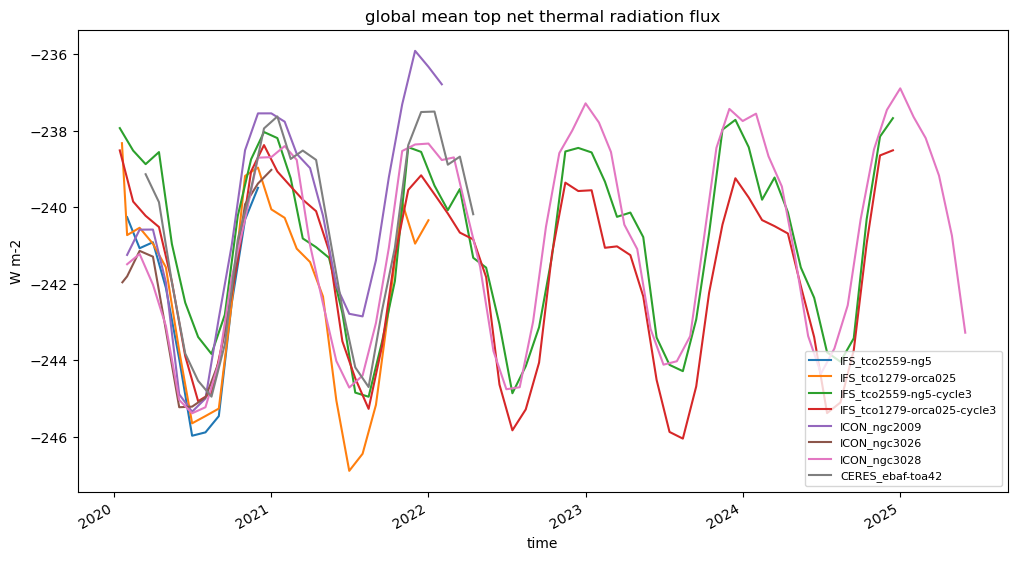

In [6]:
model_list = ["IFS", "ICON", "CERES"]
exp_name = {"IFS": ["tco2559-ng5","tco1279-orca025", "tco2559-ng5-cycle3", "tco1279-orca025-cycle3"], "ICON": ["ngc2009", "ngc3026","ngc3028"], "CERES": ["ebaf-toa42"]}
source = {"IFS": ["lra-r100-monthly"], "ICON": ["lra-r100-monthly"], "CERES": ["monthly"]}

# sign of flux is opposite in CERES data
data = {}
for model in model_list:
    for exp in exp_name[model]:
        for src in source[model]:
            if model=="CERES":
                reader = Reader(model=model, exp=exp, source=src)
                data[(model, exp)] = reader.retrieve()["toa_lw_all_mon"]
                data[(model, exp)] = reader.fldmean(data[(model, exp)][240:266]*-1)
            else:
                reader = Reader(model=model, exp=exp, source=src)
                data[(model, exp)] = reader.retrieve()["mtntrf"]
                data[(model, exp)]= reader.fldmean(data[(model, exp)])

plt.figure(figsize=(12, 6))
for model in model_list:
    for exp in exp_name[model]:
        data[(model, exp)].plot(label=f"{model}_{exp}")
plt.legend(fontsize=8)
plt.ylabel("W m-2")
plt.title("global mean top net thermal radiation flux")

Same but for SW radiation

2023-05-31 18:24:32 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco2559-ng5-cycle3, source lra-r100-monthly
2023-05-31 18:24:33 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco1279-orca025-cycle3, source lra-r100-monthly


Text(0.5, 1.0, 'global mean top net solar radiation flux')

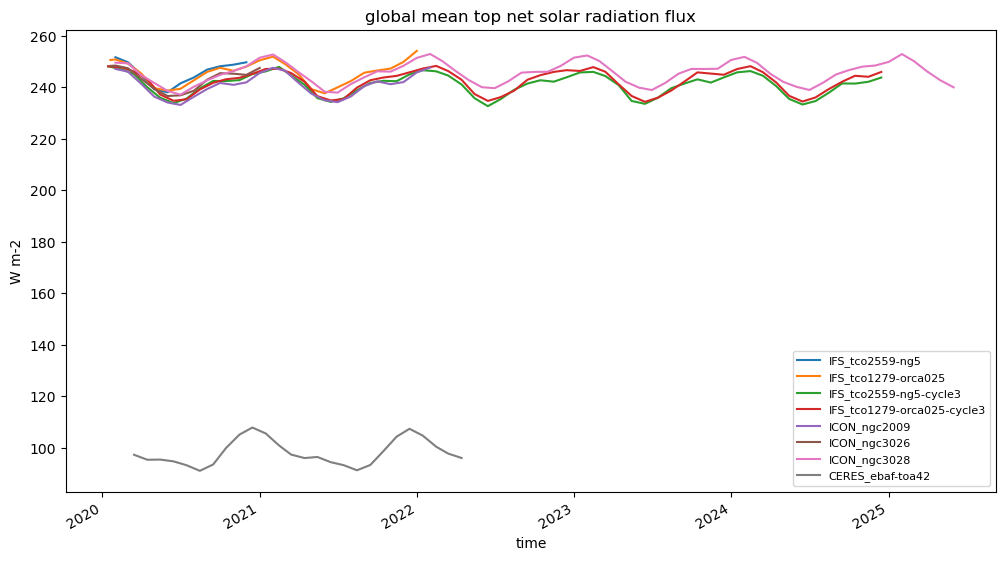

In [7]:
model_list = ["IFS", "ICON", "CERES"]
exp_name = {"IFS": ["tco2559-ng5","tco1279-orca025", "tco2559-ng5-cycle3", "tco1279-orca025-cycle3"], "ICON": ["ngc2009", "ngc3026", "ngc3028"], "CERES": ["ebaf-toa42"]}
source = {"IFS": ["lra-r100-monthly"], "ICON": ["lra-r100-monthly"], "CERES": ["monthly"]}

# sign of flux is opposite in CERES data
data = {}
for model in model_list:
    for exp in exp_name[model]:
        for src in source[model]:
            if model=="CERES":
                reader = Reader(model=model, exp=exp, source=src)
                data[(model, exp)] = reader.retrieve()["toa_sw_all_mon"]
                data[(model, exp)] = reader.fldmean(data[(model, exp)][240:266])
            else:
                reader = Reader(model=model, exp=exp, source=src)
                data[(model, exp)] = reader.retrieve()["mtnsrf"]
                data[(model, exp)]= reader.fldmean(data[(model, exp)])

plt.figure(figsize=(12, 6))
for model in model_list:
    for exp in exp_name[model]:
        data[(model, exp)].plot(label=f"{model}_{exp}")
plt.legend(fontsize=8)
plt.ylabel("W m-2")
plt.title("global mean top net solar radiation flux")

Now plot net radiation at TOA (SW-LW)

2023-05-31 18:25:22 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco2559-ng5-cycle3, source lra-r100-monthly
2023-05-31 18:25:23 :: Reader :: WARNING  -> No fixes available for model IFS, experiment tco1279-orca025-cycle3, source lra-r100-monthly


Text(0.5, 1.0, 'global mean net radiation flux at toa')

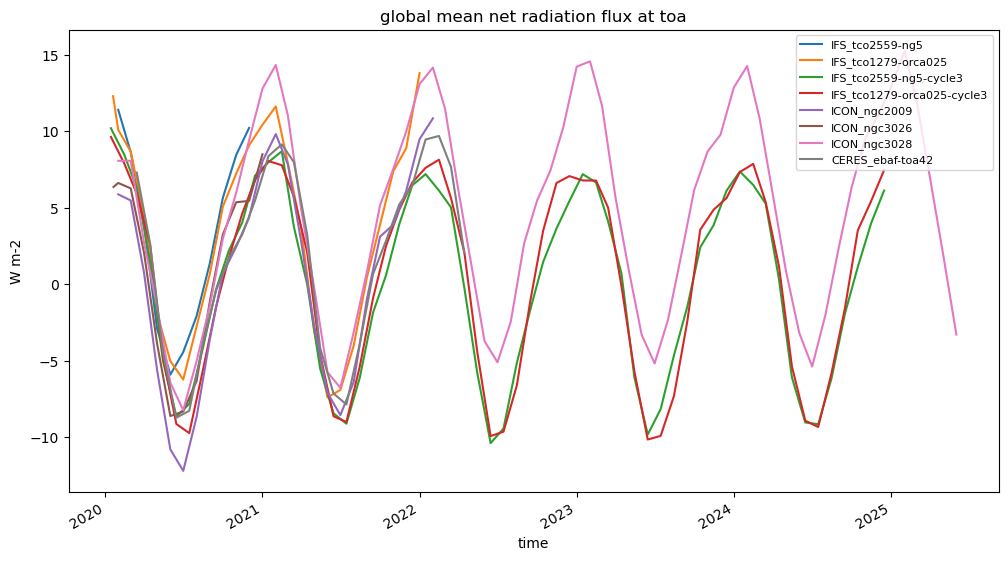

In [8]:
model_list = ["IFS", "ICON", "CERES"]
exp_name = {"IFS": ["tco2559-ng5","tco1279-orca025", "tco2559-ng5-cycle3", "tco1279-orca025-cycle3"], "ICON": ["ngc2009", "ngc3026", "ngc3028"], "CERES": ["ebaf-toa42"]}
source = {"IFS": ["lra-r100-monthly"], "ICON": ["lra-r100-monthly"], "CERES": ["monthly"]}

# sign of flux is opposite in CERES data
data = {}
for model in model_list:
    for exp in exp_name[model]:
        for src in source[model]:
            if model=="CERES":
                reader = Reader(model=model, exp=exp, source=src)
                data[(model, exp)] = reader.retrieve()["toa_net_all_mon"]
                data[(model, exp)] = reader.fldmean(data[(model, exp)][240:266])
            else:
                reader = Reader(model=model, exp=exp, source=src)
                data[(model, exp)] = reader.retrieve()["mtnsrf"] + reader.retrieve()["mtntrf"]
                data[(model, exp)]= reader.fldmean(data[(model, exp)])

plt.figure(figsize=(12, 6))
for model in model_list:
    for exp in exp_name[model]:
        data[(model, exp)].plot(label=f"{model}_{exp}")
plt.legend(fontsize=8)
plt.ylabel("W m-2")
plt.title("global mean net radiation flux at toa")